# Triangle Trading Strategy

Triangle is one of the most common chart patterns. There are three types of this pattern: ascending (maximums of prices are at the same level, minimums increase), descending (opposite to ascending), and symmetrical triangles (formed as a consolidation pattern, when a wide range of prices is gradually reduced from both sides under pressure from buyers and sellers).

We highly recommend you to search triangle method in the internet before reading this template. The main idea of triangle chart pattern one can find [here](https://www.investopedia.com/terms/t/triangle.asp). A dozen movies can describe the basic concept of this method. On the other hand, no one will tell you exactly how he finds triangles in real trading and when exactly it is worth to hold a long or short position. You need to select all parameters by yourself, based on historical data. We will do it now.

## Loading libraries and data

In [ ]:
# standart libraries
import xarray as xr
import numpy as np
import pandas as pd

import qnt.data as qndata              # data loading and manipulation
import qnt.stats as qnstats            # key statistics
import qnt.graph as qngraph            # graphical tools
import qnt.forward_looking as qnfl     # forward looking checking
import qnt.xr_talib as xrtl            # technical analysis indicators
import qnt.ta as qnta                  # for weighted moving average
from IPython.display import display    # display function for fancy displaying
import plotly.graph_objs as go         # lib for charts
import datetime as dt                  # work with date and time
import re                              # to find a substring in a string
from scipy.signal import argrelextrema # to find local extrema

In [ ]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# load crypto data
data = qndata.load_cryptocurrency_data(min_date = "2013-05-01",
                    max_date = None,
                    dims     = ("time", "field", "asset"),
                    forward_order = True)

# we will consider triangle on a bitcoin example
crypt_name = 'BTC'

btc_close = data.loc[:,"close",:].to_pandas()[crypt_name]
btc_high = data.loc[:,"high",:].to_pandas()[crypt_name]
btc_low = data.loc[:,"low",:].to_pandas()[crypt_name]
vol = data.loc[:,"vol",:].to_pandas()[crypt_name]

In [ ]:
# we can see historical data on a chart
trend_fig = [
    go.Scatter(
        x = btc_close.index,
        y = btc_close.values,
        name="BTC Close",
        line = dict(width=1,color='black')),
    go.Scatter(
        x = btc_high.index,
        y = btc_high.values,
        name="BTC High",
        line = dict(width=1,color='green')),
    go.Scatter(
        x = btc_low.index,
        y = btc_low.values,
        name="BTC Low",
        line = dict(width=1,color='orange'))]

# draw chart
fig = go.Figure(data = trend_fig)
fig.update_yaxes(fixedrange=False) # unlock vertical scrolling
fig.show()

## Find triangles

We will try to find a triangles by the following algorithm:
1. Find maximum and minimum points in a "window range" time frame (in this case in hours)
2. Find a triangle by extrema
    + Find the desired order of extrema. For instance - [max,min,max,min]
    + Build two lines - at the highs and lows, respectively
3. Check triangle parameters

The next three cells are simply functions that perform items 1-3

In [ ]:
def min_max_points(low, high, window_range = 10):
    """
    :param low: low values of the instrument
    :param high: high values of the instrument
    :param window_range: look back days
    :return: dataframe with selected extrema
    notion: there is always 1 look forward day
    """
    
    # make a list of local maximums and local minimums
    local_max = argrelextrema(high.values, np.greater)[0]
    local_min = argrelextrema(low.values, np.less)[0]
    
    # we look back in a "window_range" days and select "global extremum" for these days
    # maximum
    price_local_max_dt = []
    for i in local_max:
        if (i>window_range) and (i<len(high)-window_range):
            loop_ind = local_max[(local_max>=i-window_range) & (local_max<=i)]
            price_local_max_dt.append(high.iloc[loop_ind].idxmax())

    maxima = pd.DataFrame(high.loc[price_local_max_dt])
    # mark them as maximum with "1"
    maxima_lbls = pd.DataFrame(np.ones(shape = (len(price_local_max_dt),)),index = maxima.index, columns = ['extremum'])
    maxima = pd.concat([maxima, maxima_lbls],axis = 1).sort_index()
    
    # minimum
    price_local_min_dt = []
    for i in local_min:
        if (i>window_range) and (i<len(low)-window_range):
            loop_ind = local_min[(local_min>=i-window_range) & (local_min<=i)]
            price_local_min_dt.append(low.iloc[loop_ind].idxmin())  
    
    minima = pd.DataFrame(low.loc[price_local_min_dt] )
    # mark them as minimum with "0"
    minima_lbls = pd.DataFrame(np.zeros(shape = (len(price_local_min_dt),)),index = minima.index, columns = ['extremum'])
    minima = pd.concat([minima, minima_lbls],axis = 1).sort_index()
    
    # combine, sort, and remove duplicated
    max_min = pd.concat([maxima, minima]).sort_index()
    max_min.index.name = 'date'
    max_min = max_min.reset_index()
    max_min = max_min[~max_min.date.duplicated()]
    
    return max_min

In [ ]:
def find_triangle(start_hour, extrema, local_pattern):
    """
    :param start_hour: reference (start) date of trading
    :param extrema: dataframe with all extrema and date
    :param local_pattern: desired sequence of extrema
    :return triangle: list of selected triangles with detection date, index and trade signal
    :return V1,V2: list of linear equation coefficients for line 1 and 2 for all triangles
    :return V1_val,V2_val: point coordinates for each line for all triangles
    """
    
    triangle = []
    V1,V1_val = [[],[]]
    V2,V2_val = [[],[]]

    # find a substring in a string (local pattern in a list of extrema)
    move_string = ''.join([str(int(i)) for i in extrema['extremum'].values]) 
    indexis = [(m.start(1), m.end(1)) for m in re.finditer(r'(?=(' + local_pattern + '))',move_string)]
    point_index = [np.linspace(i[0],i[1]-1,len(local_pattern),dtype='int32') for i in indexis]
    
    # for detected triangles in history:
    for i in range(len(point_index)):

        # Define the line equetion
        # first line index
        fli = [n.start() for n in re.finditer("1",local_pattern)]
        # second line index
        sli = [n.start() for n in re.finditer("0",local_pattern)]

        # for the first line
        local_y1 = extrema.iloc[point_index[i]][crypt_name].iloc[fli]
        local_x1 = [(i - start_hour).seconds//3600 + (i - start_hour).days*24 for i in extrema.iloc[point_index[i]].date.iloc[fli].values]
        A = np.vstack([np.ones(shape = (len(fli),)),local_x1]).T

        v_1 = np.linalg.inv(A.T@A)@A.T@local_y1
        V1.append(v_1)
        V1_val.append(np.vstack([local_x1,local_y1.values]))

        # for the second line
        local_y2 = extrema.iloc[point_index[i]][crypt_name].iloc[sli]
        local_x2 = [(i - start_hour).seconds//3600 + (i - start_hour).days*24 for i in extrema.iloc[point_index[i]].date.iloc[sli].values]
        A = np.vstack([np.ones(shape = (len(sli),)),local_x2]).T

        v_2 = np.linalg.inv(A.T@A)@A.T@local_y2
        V2.append(v_2)
        V2_val.append(np.vstack([local_x2,local_y2.values]))

        # Hour of triangle detection
        detection_hour = extrema.iloc[point_index[i]].date.iloc[-1]
        
        # Check triangle parameters and recieve trade decision
        triangle_flag, trade_signal = triangle_check(v_1,v_2,local_x1,local_x2,local_y1,local_y2)

        # If triangle parameters are appropriate - save it
        if triangle_flag == True:
            triangle.append([trade_signal,detection_hour,i])
            
    return triangle, V1, V1_val, V2, V2_val

In [ ]:
def triangle_check(line1,line2,points_x1,points_x2,points_y1,points_y2):
    """
    :param line1, line2: linear equation coefficients for line 1 and 2
    :param points_x1, points_x2: extrema coordinates on X-axis
    :param points_y1, points_y2: extrema coordinates on Y-axis
    :return triangle_flag: True if the triangle fits all conditions
    :return trade_signal: +1 if it is a signal to buy; -1 for sell
    """
    #
    vals = np.hstack([points_y1.values,points_y2.values])
    cors = np.hstack([points_x1,points_x2])
    
    # Triangle must converge and converge fast
    x0 = (line2[0] - line1[0])/(line1[1] - line2[1])
    y0 = line1[1]*x0 + line1[0]
    
    # 4 is an imperical parameter. You can choose another one
    if (x0 - max(cors))>0 and (x0 - max(cors))<(max(cors) - min(cors))*4: 
        converge = True
    else:
        converge = False

    # triangle should be big enough
    triangle_height = abs(points_y1.iloc[0] - line2[0] - line2[1]*min(points_x2))
    
    if triangle_height/points_y1.iloc[0] < 0.001: # it is an imperical parameter. You can choose another one
        hflag = False
    else:
        hflag = True

    # one line should be more or less horisontal
    zero_flag = True

    if abs(y0/max(vals) - 1) < 0.002: # You can choose another one.
        # If the top line is horizontal, it is a signal to buy
        trade_signal = 1
    elif abs(y0/min(vals) - 1) < 0.002: # You can choose another one.
        # If the bottom line is horisontal, it is a signal to sell
        trade_signal = -1
    else:
        trade_signal = 0
        zero_flag = False
    
    hflag = True
    return converge*hflag*zero_flag, trade_signal

We can come up with a list of parameters that the triangle must satisfy (see triangle_check function):
1. Triangle must converge
    + Two lines should intersect to the right of the pattern found. The intersection should not be too far (no further than a few length of the triangle).
2. Triangle must be big enough
    + Minor price fluctuations can create the desired sequence of extremes but will not be a strong signal to trade.
3. One line must be more or less horisontal
    + We will only consider ascending and descending triangles.

#### Lets have a closer look to extrema and resulting triangles

In [ ]:
# first we can choose "window range" for selecting extrema (in this case in hours)
wr = 10

# dataframe with extrema list
min_max = min_max_points(btc_low, btc_high, wr)

# For instance, we will search triangle based on the following pattern: 
pattern = '1010' # [maximum, minimum, maximum, minimum]

In [ ]:
# We need to set a reference day for all triangles to make their equations consistent
start_date = btc_close.index[0]

# triangles that we found
tr_param, v1, val1, v2, val2 = find_triangle(start_date, min_max, pattern)

# Info
print(f"All 'triangles' found in a history: {len(v1)}")
print(f"Triangles that satisfy all parameters: {len(tr_param)}")

In the cell below you can analize selected traingles in order to tune parameters in the triangle_check function.

In [ ]:
# triangle number we look at (among all 'triangles'):
tr_look = 0

# prepare desired timeframe
local_date = start_date + dt.timedelta(hours = val1[tr_look][0,0])
time_temp = btc_close[local_date - dt.timedelta(hours = 100) :local_date + dt.timedelta(hours = 100)].index

# just print an example
# min max points
Min_max =[
    go.Scatter(
        x = min_max['date'],
        y = min_max[crypt_name],
        name="Selected extremum",
        mode="markers",
        hovertext='stop',
        marker_size=9,
        line = dict(width=1,color='green')
    )]
    
# triangle extrema
local_triangle = [
    go.Scatter(
        x = [start_date + dt.timedelta(hours = i) for i in np.hstack([val1[tr_look][0],val2[tr_look][0]])],
        y = np.hstack([val1[tr_look][1],val2[tr_look][1]]),
        name="Triangle example",
        mode="markers",
        hovertext='stop',
        marker_size=9,
        line = dict(width=1,color='blue')
    ), # two lines - triangle edges
    go.Scatter(
        x = time_temp,
        y = v1[tr_look][0] + v1[tr_look][1]*((time_temp-start_date).days*24 + (time_temp-start_date).seconds//3600),
        name="First trading line",
        line = dict(width=1,color='green')
    ),
    go.Scatter(
        x = time_temp,
        y = v2[tr_look][0] + v2[tr_look][1]*((time_temp-start_date).days*24 + (time_temp-start_date).seconds//3600),
        name="Second trading line",
        line = dict(width=1,color='orange')
    )]

# We print whether it pass all filters
if sum(np.array(tr_param)[:,2] == tr_look):
    print("This triangle pass all filters")
else:
    print("This is not a triangle")

# draw chart
fig = go.Figure(data = trend_fig + Min_max + local_triangle)
fig.update_yaxes(fixedrange=False) # unlock vertical scrolling
fig.show()

## Trade

Here we make the assumption that it is reasonable to trade long if the last extremum in the pattern is a minimum and vice versa.

You can create and implement any other approach as you wish.

In a more details. For a long position we will wait when price hit the high limit twice and each time price rebound smaller than the previous one. We can set a long position after the second price minimum in this triangle (1 hour after to avoid forward looking):

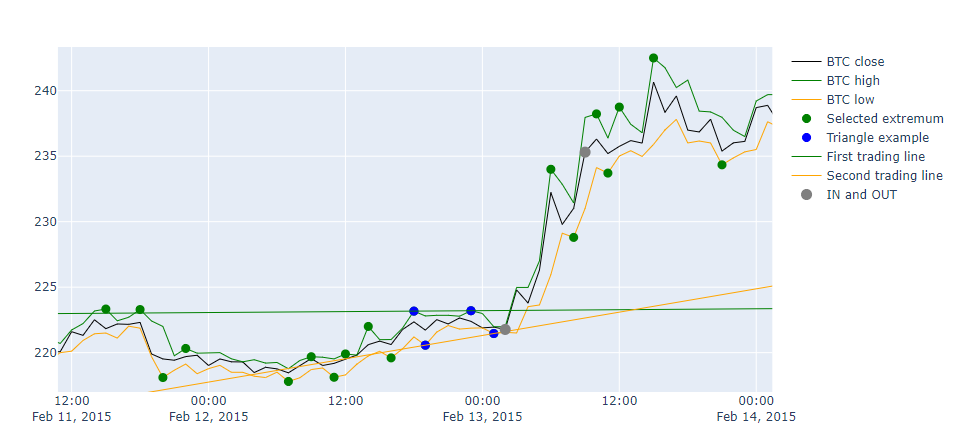

For a short position, everything happens the other way around:

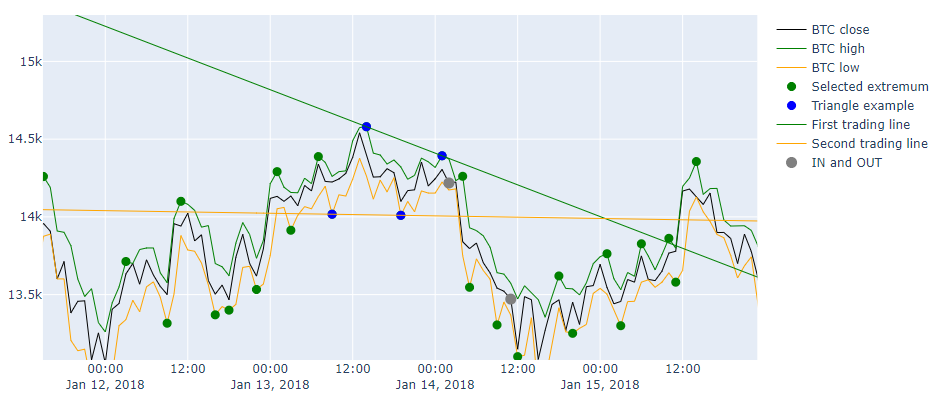

The trade function is simply a rule that make a trade decision based on the triangle. 

In [ ]:
def trade(close_val, triangle, val1, val2, trade_hours, percent, local_pattern):
    """
    :param close_val: close values of the instrument
    :param triangle: a list of selected triangles with trade signals and detection dates
    :param val1, val2: extrema coordinates on Y-axis
    :param trade_hours: the maximum trade hours after triangle detection
    :param percent: profit we want to gain on each triangle in percents
    :param local_pattern: the triangle pattern we use right now
    :return sold_buy: a list of trade decisions in format: [weigth, date IN, date OUT]
    :return trade_index: indexis of trade triangles (for debag)
    """
    sold_buy = []
    trade_index = []
    
    # convert the parameter into fractions of units
    percent = percent/100
    
    # for detected triangles 
    for i in triangle:
        zero_line = i[0]
        det_hour = i[1]
        
        # As we discussed already we set long position in the only one case:
        # the upper line is horisontal and last extremum is minimum
        # and vice versa for a short position
        if (zero_line == 1 and local_pattern[-1] == '0') or (zero_line == -1 and local_pattern[-1] == '1'):    
                [flag1,flag2,flag3] = [False,False,False]
                in_flag = False
                
                # in available trading hours...
                for k in range(trade_hours):
                    try:
                        day_number = det_hour + dt.timedelta(hours=int(k + 1)) # "+1 hour" avoids forward looking
                        loop_price = close_val[day_number]
                        
                        # IN -----------------------------------------------------------------------------
                        # we want ot go IN inside the triangle to make the best profit
                        if in_flag==False:
                            in_flag = True
                            IN = [zero_line,day_number]
                            in_price = loop_price

                        # OUT ----------------------------------------------------------------------------
                        # fisrt calsulations
                        wma_price = qnta.wma(close_val,15)
                        progress_sign = np.sign(wma_price[wma_price.index==day_number] - wma_price[wma_price.index<day_number][-1])
                        loop_height = (loop_price - in_price)
                        
                        # Three indicators we are lookinf for to go OUT:
                        # 1. to much fall for a worse case
                        if (loop_price<np.min(val2[i[2]])) and (IN[0]>0):
                            flag1 = True

                        if (loop_price>np.max(val1[i[2]])) and (IN[0]<0):
                            flag1 = True

                        # 2. goal is complite
                        if (loop_height/in_price>percent) or (progress_sign[0]<=0):
                            if (IN[0]>0):
                                flag2 = True

                        if (loop_height/in_price<-percent) or (progress_sign[0]>=0):
                            if (IN[0]<0):
                                flag2 = True

                        # 3. to many days waiting
                        if (k > trade_hours-2):
                            flag3 = True

                        # Now check conditions for this hour
                        if flag1 or flag2 or flag3:
                            IN.append(day_number)
                            sold_buy.append(IN)
                            trade_index.append(i[2])
#                             print([flag1,flag2,flag3, day_number],i)
                            [flag1,flag2,flag3] = [False,False,False]
                            break
                    except:
#                         raise
                        continue
    return sold_buy, trade_index

In [ ]:
# parameters
percent = 5       # profit we want to gain on each triangle
trade_hours = 60  # the maximum number of hours we can trade on one triangle

# just to remind that our pattern suppose long position
pattern = '1010'

buy_sold, trade_index = trade(btc_close, tr_param, np.array(val1)[:,1], np.array(val2)[:,1], trade_hours, percent, pattern)

We can visualize our trade decisions. You can analize it in order to tune parameters in the trade function.

In [ ]:
# Info
print(f"The number of trade triangles = {len(buy_sold)}")

In [ ]:
# triangle number we look at (among trade triangles):
tr_look = 0

# prepare desired timeframe
tr_index = trade_index[tr_look]
local_date = start_date + dt.timedelta(hours = val1[tr_index][0,0])
time_temp = btc_close[local_date - dt.timedelta(hours = 100) :local_date + dt.timedelta(hours = 100)].index

# just print an example
local_triangle =[
    go.Scatter(
        x = [start_date + dt.timedelta(hours = i) for i in np.hstack([val1[tr_index][0],val2[tr_index][0]])],
        y = np.hstack([val1[tr_index][1],val2[tr_index][1]]),
        name="Triangle example",
        mode="markers",
        hovertext='stop',
        marker_size=9,
        line = dict(width=1,color='blue')
    ), # two lines - triangle edges
    go.Scatter(
        x = time_temp,
        y = v1[tr_index][0] + v1[tr_index][1]*((time_temp-start_date).days*24 + (time_temp-start_date).seconds//3600),
        name="First trading line",
        line = dict(width=1,color='green')
    ),
    go.Scatter(
        x = time_temp,
        y = v2[tr_index][0] + v2[tr_index][1]*((time_temp-start_date).days*24 + (time_temp-start_date).seconds//3600),
        name="Second trading line",
        line = dict(width=1,color='orange')
    )]

# In and OUT
in_out_fig = [
    go.Scatter(
    x = buy_sold[tr_look][1:3:1],
    y = btc_close[buy_sold[tr_look][1:3:1]].values,
    name="IN and OUT",
    mode="markers",
    hovertext='stop',
    marker_size=9,
    line = dict(width=1,color='grey')
    )]

# draw chart
fig = go.Figure(data = trend_fig + local_triangle + in_out_fig)
fig.update_yaxes(fixedrange=False) # unlock vertical scrolling
fig.show()

Now we are ready to form the strategy implementing all the above functions step by step:

In [ ]:
# select a window range 
wr = 10

# we want patterns both for long and short positions:
pattern_list = ["1010","0101"]

# parameters
percent = 5       # profit we want to gain on each triangle
trade_hours = 60  # the maximum number of hours we can trade on one triangle

# trade decision for a loop
buy_sold_temp = []

# for pattern in pattern list...
for pattern in pattern_list:
    # we repeat all above steps for each pattern
    min_max = min_max_points(btc_low, btc_high, wr)
    tr_param, v1, val1, v2, val2 = find_triangle(start_date, min_max, pattern)
    # append trade decisions
    temp, _ = trade(btc_close, tr_param, np.array(val1)[:,1], np.array(val2)[:,1], trade_hours, percent, pattern)
    buy_sold_temp.append(temp)

# combine decisions
buy_sold = np.vstack([buy_sold_temp[0],buy_sold_temp[1]])

## Strategy evaluation

The cell below is just a standart function for the algorithm evaluation.

In [ ]:
def print_stat(stat):
    """Prints selected statistical key indicators:
       - the global Sharpe ratio of the strategy;
       - the global mean profit;
       - the global volatility;
       - the maximum drawdown.

       Note that Sharpe ratio, mean profit and volatility
       apply to  max simulation period, and not to the
       rolling basis of 3 years.
    """

    days = len(stat.coords["time"])
    
    returns = stat.loc[:, "relative_return"]

    equity = stat.loc[:, "equity"]
    
    sharpe_ratio = qnstats.calc_sharpe_ratio_annualized(
        returns,
        max_periods=days,
        min_periods=days).to_pandas().values[-1]

    profit = (qnstats.calc_mean_return_annualized(
        returns,
        max_periods=days,
        min_periods=days).to_pandas().values[-1])*100.0

    volatility = (qnstats.calc_volatility_annualized(
        returns,
        max_periods=days,
        min_periods=days).to_pandas().values[-1])*100.0

    max_ddown = (qnstats.calc_max_drawdown(
        qnstats.calc_underwater(equity)).to_pandas().values[-1])*100.0

    print("Sharpe Ratio         : ", "{0:.3f}".format(sharpe_ratio))
    print("Mean Return [%]      : ", "{0:.3f}".format(profit))
    print("Volatility [%]       : ", "{0:.3f}".format(volatility))
    print("Maximum Drawdown [%] : ", "{0:.3f}".format(-max_ddown))

In [ ]:
# form weights of the portfolio
weights = data.loc[:,"vol",:].to_pandas().copy(deep = True)
weights[:] = 0

# for trade decisions in a buy_sold list...
for j in buy_sold:
    index = (weights.index>=j[1])*(weights.index<=j[2])
    weights[crypt_name][index] = weights[crypt_name][index] + j[0]

# output
output = xr.DataArray(weights.values, dims = ["time","asset"], coords= {"time":weights.index,"asset":weights.columns} )

# calculate statistics
stat = qnstats.calc_stat(data, output, slippage_factor=0.05)
print_stat(stat)

# show plot with profit and losses:
performance = stat.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

## What can be changed?

Everything.
Here is a suggested list of what can be improved:
1. Use another time-frame. 
    + The method of triangles is quite universal and is traded at different time intervals. It must be taken into account that for different periods of time different parameters of the triangle are needed.
2. Tune triangle_check function. Or you can choose your own rule and list of conditions.
3. One can change pattern.
4. Trade algorithm. 
    + You can create your own rule on how to trade: the right time for long and short positions. Some traders use additional information. For example, volume.
    + One can combine trade solutions not only from different patterns but also from different time-frames.
5. Reference points search.
    + You can change the search algorithm for reference points (extrema in our case). One can even come up with a completely different algorithm for constructing triangles.

## Submit

In [ ]:
def strategy():
    data = qndata.load_cryptocurrency_data(min_date = "2013-05-01",
                        max_date = None,
                        dims     = ("time", "field", "asset"),
                        forward_order = True)
    
    crypt_name = 'BTC'
    btc_close = data.loc[:,"close",:].to_pandas()[crypt_name]
    btc_high = data.loc[:,"high",:].to_pandas()[crypt_name]
    btc_low = data.loc[:,"low",:].to_pandas()[crypt_name]
    
    start_date = start_date = btc_close.index[0]
    
    wr = 10
    percent = 5   # profit we want to gain on each triangle
    trade_hours = 60 # the maximum number of hours we can trade on one triangle
    pattern_list = ["1010","0101"]
    buy_sold_temp = []

    for pattern in pattern_list:
        min_max = min_max_points(btc_low,btc_high,wr)
        tr_param, v1, val1, v2, val2 = find_triangle(start_date, min_max, pattern)
        temp, _ = trade(btc_close, tr_param, np.array(val1)[:,1], np.array(val2)[:,1], trade_hours, percent, pattern)
        buy_sold_temp.append(temp)
        
    buy_sold = np.vstack([buy_sold_temp[0],buy_sold_temp[1]])
    
    weights = data.loc[:,"vol",:].to_pandas().copy(deep = True)
    weights[:] = 0

    for j in buy_sold:
        index = (weights.index>=j[1])*(weights.index<=j[2])
        weights[crypt_name][index] = weights[crypt_name][index] + j[0]

    output = xr.DataArray(weights.values, dims = ["time","asset"], coords= {"time":weights.index,"asset":weights.columns} )
        
    return output

In [ ]:
output_final = qnfl.load_data_calc_output_and_check_forward_looking(strategy)